Check available GPU

In [37]:
!nvidia-smi

Mon Nov 21 16:05:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   62C    P8     3W /  N/A |   1498MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import Liabraries

In [38]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.auto import tqdm
import time
#from google.colab import drive
#drive.mount('/content/gdrive')
import matplotlib.pyplot as plt

device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#FILE_PATH = '/content/gdrive/MyDrive/5340project/'
BATCH_SIZE = 256

cuda:0


Load Dataset

In [39]:
def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform)
    test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform)
    print('Number of training data:', len(train_data))
    print('Number of testing data:', len(test_data))

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    return train_data, test_data, train_loader, test_loader
  
train_data, test_data, train_loader, test_loader = load_data()

Files already downloaded and verified
Files already downloaded and verified
Number of training data: 50000
Number of testing data: 10000


Build Model Structure

In [40]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(3, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

Define training and testing loop

In [44]:
def evaluate(model, test_loader, opt_name, loss_func):
    total_loss = 0
    correct = 0
    num_labels = 0
    counter = 0
    test_loss=0
    test_accuracy = 0
    model.eval()
    for batch_idx, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)

        output = model(X)

        loss = loss_func(output, y)
        total_loss += loss.item()

        predicted = torch.max(output,1)[1]
        correct += (predicted == y).sum()
        num_labels += len(y)
        counter += 1
    log = 'Test Loss %4f, Test Accuracy %4f' % (total_loss/counter, correct/num_labels)
    print(log)
    with open(str(opt_name) + ' Testing log.txt', 'w') as f:
        f.write(log)
    test_loss = (total_loss/counter)
    test_accuracy = (correct/num_labels).cpu().item()
    return test_loss, test_accuracy

In [46]:
def train(model, train_loader, optimizer, opt_name, loss_func, epochs=15):
    accuracy_lst = []
    loss_lst = []
    testaccuracy_lst = []
    testloss_lst = []
    log = []
    model.train()
    start_time = time.time()
    for epoch in tqdm(range(epochs), desc=f"Training progress "+opt_name, colour="#00ff00"):
        total_loss = 0
        correct = 0
        num_labels = 0
        counter = 0
        for batch_idx, (X, y) in enumerate(tqdm(train_loader, leave=False, desc=f"Epoch {epoch + 1}/{epochs}", colour="#005500")):
            X = X.to(device)
            y = y.to(device)
            if opt_name == 'LBFGS':
                def loss_closure():
                    optimizer.zero_grad()
                    oupt = model(X)
                    loss_val = loss_func(oupt, y)
                    loss_val.backward()
                    return loss_val
                optimizer.step(loss_closure)
                output = model(X)  # monitor loss
                loss = loss_closure() 
                total_loss += loss.item() 
            elif opt_name == 'AdaHessian':
                optimizer.zero_grad()
                output = model(X)
                loss = loss_func(output, y)
                total_loss += loss.item()
                loss.backward(create_graph=True)
                optimizer.step()
            else:
                optimizer.zero_grad()
                output = model(X)
                loss = loss_func(output, y)
                total_loss += loss.item()
                loss.backward()
                optimizer.step()

            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == y).sum()
            num_labels += len(y)
            counter += 1
        accuracy_lst.append((correct/num_labels).cpu().item())
        loss_lst.append(total_loss/counter)
        tmp_log = 'Epoch %d, Loss %4f, Accuracy %4f' % (epoch+1, total_loss/counter, correct/num_labels)
        print(tmp_log)
        log.append(tmp_log)
        test_loss, test_accuracy = evaluate(model, test_loader, opt_name, loss_func)
        testloss_lst.append(test_loss)
        testaccuracy_lst.append(test_accuracy)
    end_time = time.time()
    print('Total Time: %4fs' % (end_time-start_time))
    with open(opt_name + ' Training log.txt', 'w') as f:
        for each in log:
            f.write(each)
            f.write('\n')
    
    return accuracy_lst, loss_lst, testaccuracy_lst, testloss_lst

Traing with different optimizers

In [47]:
lr = 0.01

# SGD
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

accuracy_lst_SGD, loss_lst_SGD, testacc_SGD, testloss_SGD = train(model, train_loader, optimizer, 'SGD', loss_func)


Training progress SGD:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Loss 1.679062, Accuracy 0.410580
Test Loss 1.616136, Test Accuracy 0.443740


Epoch 2/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 1.364333, Accuracy 0.527140
Test Loss 1.246447, Test Accuracy 0.561040


Epoch 3/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 1.168754, Accuracy 0.591540
Test Loss 1.119213, Test Accuracy 0.600520


Epoch 4/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 1.064313, Accuracy 0.631540
Test Loss 1.234143, Test Accuracy 0.579080


Epoch 5/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 0.990091, Accuracy 0.658420
Test Loss 1.010414, Test Accuracy 0.642800


Epoch 6/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 0.928210, Accuracy 0.679080
Test Loss 0.915720, Test Accuracy 0.679480


Epoch 7/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 0.877854, Accuracy 0.699180
Test Loss 0.904013, Test Accuracy 0.683640


Epoch 8/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 0.840864, Accuracy 0.711880
Test Loss 0.806078, Test Accuracy 0.721260


Epoch 9/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Loss 0.799881, Accuracy 0.724120
Test Loss 0.814846, Test Accuracy 0.717280


Epoch 10/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Loss 0.765883, Accuracy 0.734960
Test Loss 0.771450, Test Accuracy 0.733480


Epoch 11/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Loss 0.744423, Accuracy 0.743920
Test Loss 0.799306, Test Accuracy 0.723520


Epoch 12/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Loss 0.715904, Accuracy 0.755500
Test Loss 0.807554, Test Accuracy 0.721260


Epoch 13/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Loss 0.686659, Accuracy 0.765640
Test Loss 0.665937, Test Accuracy 0.773520


Epoch 14/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Loss 0.661205, Accuracy 0.772060
Test Loss 0.670465, Test Accuracy 0.767800


Epoch 15/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Loss 0.643251, Accuracy 0.778680
Test Loss 0.674390, Test Accuracy 0.762120
Total Time: 386.216811s


In [48]:
# Adam
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

accuracy_lst_Adam, loss_lst_Adam, testacc_Adam, testloss_Adam = train(model, train_loader, optimizer, 'Adam', loss_func)


Training progress Adam:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Loss 2.989720, Accuracy 0.380740
Test Loss 1.408590, Test Accuracy 0.496800


Epoch 2/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 1.283202, Accuracy 0.543820
Test Loss 1.104653, Test Accuracy 0.619320


Epoch 3/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 1.065461, Accuracy 0.625120
Test Loss 0.970942, Test Accuracy 0.663820


Epoch 4/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 0.938462, Accuracy 0.672480
Test Loss 0.848744, Test Accuracy 0.705620


Epoch 5/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 0.848130, Accuracy 0.705500
Test Loss 0.762452, Test Accuracy 0.736340


Epoch 6/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 0.781782, Accuracy 0.729620
Test Loss 0.683268, Test Accuracy 0.762100


Epoch 7/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 0.725138, Accuracy 0.748140
Test Loss 0.650227, Test Accuracy 0.776480


Epoch 8/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 0.663454, Accuracy 0.770920
Test Loss 0.569918, Test Accuracy 0.803080


Epoch 9/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Loss 0.631650, Accuracy 0.780080
Test Loss 0.536178, Test Accuracy 0.817640


Epoch 10/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Loss 0.579685, Accuracy 0.798640
Test Loss 0.496100, Test Accuracy 0.832060


Epoch 11/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Loss 0.542348, Accuracy 0.811400
Test Loss 0.478194, Test Accuracy 0.833460


Epoch 12/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Loss 0.524050, Accuracy 0.815180
Test Loss 0.457134, Test Accuracy 0.842100


Epoch 13/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Loss 0.483586, Accuracy 0.829760
Test Loss 0.416019, Test Accuracy 0.854500


Epoch 14/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Loss 0.449746, Accuracy 0.843220
Test Loss 0.344142, Test Accuracy 0.882520


Epoch 15/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Loss 0.435294, Accuracy 0.845960
Test Loss 0.355860, Test Accuracy 0.874480
Total Time: 385.641227s


In [49]:
# NAdam
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr = lr)

accuracy_lst_NAdam, loss_lst_NAdam, testacc_NAdam, testloss_NAdam = train(model, train_loader, optimizer, 'NAdam', loss_func)

Training progress NAdam:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Loss 2.464024, Accuracy 0.402960
Test Loss 1.453132, Test Accuracy 0.495460


Epoch 2/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 1.433692, Accuracy 0.494100
Test Loss 1.152264, Test Accuracy 0.589100


Epoch 3/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 1.087517, Accuracy 0.619320
Test Loss 1.013679, Test Accuracy 0.642940


Epoch 4/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 0.957466, Accuracy 0.667320
Test Loss 0.847092, Test Accuracy 0.709880


Epoch 5/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 0.856502, Accuracy 0.703460
Test Loss 0.827592, Test Accuracy 0.705740


Epoch 6/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 0.789541, Accuracy 0.726740
Test Loss 0.737637, Test Accuracy 0.738720


Epoch 7/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 0.728500, Accuracy 0.746160
Test Loss 0.804669, Test Accuracy 0.719340


Epoch 8/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 0.678110, Accuracy 0.762620
Test Loss 0.656914, Test Accuracy 0.771000


Epoch 9/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Loss 0.634626, Accuracy 0.780800
Test Loss 0.555597, Test Accuracy 0.808280


Epoch 10/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Loss 0.596218, Accuracy 0.790640
Test Loss 0.551764, Test Accuracy 0.808140


Epoch 11/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Loss 0.553572, Accuracy 0.807140
Test Loss 0.664973, Test Accuracy 0.765420


Epoch 12/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Loss 0.525818, Accuracy 0.814680
Test Loss 0.524417, Test Accuracy 0.811680


Epoch 13/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Loss 0.495627, Accuracy 0.826900
Test Loss 0.582528, Test Accuracy 0.794800


Epoch 14/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Loss 0.462083, Accuracy 0.837160
Test Loss 0.444251, Test Accuracy 0.844740


Epoch 15/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Loss 0.436864, Accuracy 0.845200
Test Loss 0.410508, Test Accuracy 0.855380
Total Time: 388.368597s


In [50]:
# RMSprop
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr = lr)

accuracy_lst_RMSprop, loss_lst_RMSprop, testacc_RMSProp, testloss_RMSProp = train(model, train_loader, optimizer, 'RMSprop', loss_func)

Training progress RMSprop:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Loss 5.174144, Accuracy 0.363040
Test Loss 1.700606, Test Accuracy 0.413320


Epoch 2/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 1.537724, Accuracy 0.462180
Test Loss 1.459622, Test Accuracy 0.468380


Epoch 3/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 1.291800, Accuracy 0.542840
Test Loss 1.366835, Test Accuracy 0.531780


Epoch 4/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 1.169388, Accuracy 0.593100
Test Loss 1.137517, Test Accuracy 0.599880


Epoch 5/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 1.065289, Accuracy 0.627020
Test Loss 0.959955, Test Accuracy 0.663840


Epoch 6/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 0.978782, Accuracy 0.660160
Test Loss 1.164890, Test Accuracy 0.588600


Epoch 7/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 0.910134, Accuracy 0.683060
Test Loss 1.013135, Test Accuracy 0.648160


Epoch 8/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 0.844403, Accuracy 0.709260
Test Loss 0.814701, Test Accuracy 0.716760


Epoch 9/15:   0%|          | 0/196 [00:00<?, ?it/s]

In [ ]:
'''
# LBFGS
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr = lr)

accuracy_lst_LBFGS, loss_lst_LBFGS = train(model, train_loader, optimizer, 'LBFGS', loss_func)
evaluate(model, test_loader, 'LBFGS', loss_func)
'''

"\n# LBFGS\nmodel = CNN().to(device)\nloss_func = nn.CrossEntropyLoss()\noptimizer = torch.optim.LBFGS(model.parameters(), lr = lr)\n\naccuracy_lst_LBFGS, loss_lst_LBFGS = train(model, train_loader, optimizer, 'LBFGS', loss_func)\nevaluate(model, test_loader, 'LBFGS', loss_func)\n"

In [ ]:
# AdaHessian
from optim_adahessian import Adahessian
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = Adahessian(model.parameters(), lr = lr)

accuracy_lst_Adahess, loss_lst_Adahess, testacc_Adahess, testloss_Adahess = train(model, train_loader, optimizer, 'AdaHessian', loss_func)

Training progress AdaHessian:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15:   0%|          | 0/196 [00:00<?, ?it/s]

d:\Users\Gautam\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\autograd\__init__.py:197: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ..\torch\csrc\autograd\engine.cpp:1064.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Loss 1.709923, Accuracy 0.405240


Epoch 2/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 1.341671, Accuracy 0.530640


Epoch 3/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 1.206676, Accuracy 0.584940


Epoch 4/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 1.120887, Accuracy 0.614600


Epoch 5/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 1.057052, Accuracy 0.638980


Epoch 6/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 1.007686, Accuracy 0.654940


Epoch 7/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 0.968105, Accuracy 0.668360


Epoch 8/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 0.934930, Accuracy 0.681560


Epoch 9/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Loss 0.911300, Accuracy 0.690940


Epoch 10/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Loss 0.885604, Accuracy 0.699620


Epoch 11/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Loss 0.864834, Accuracy 0.706460


Epoch 12/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Loss 0.844180, Accuracy 0.715180


Epoch 13/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Loss 0.826768, Accuracy 0.720320


Epoch 14/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Loss 0.809407, Accuracy 0.727740


Epoch 15/15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Loss 0.794423, Accuracy 0.733740
Total Time: 269.525076s
Test Loss 0.793804, Test Accuracy 0.732920


In [ ]:
Display Results

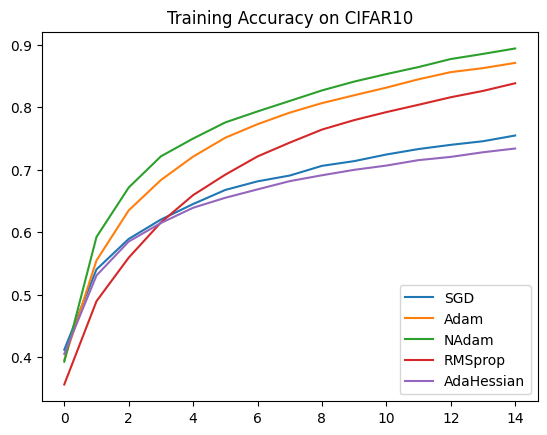

In [ ]:
epoch_lst = range(15)
plt.plot(epoch_lst, accuracy_lst_SGD, label = "SGD")
plt.plot(epoch_lst, accuracy_lst_Adam, label = "Adam")
plt.plot(epoch_lst, accuracy_lst_NAdam, label = "NAdam")
plt.plot(epoch_lst, accuracy_lst_RMSprop, label = "RMSprop")
plt.plot(epoch_lst, accuracy_lst_Adahess, label = "AdaHessian")
plt.legend()
plt.title('Training Accuracy on CIFAR10')
plt.savefig('Training Accuracy on CIFAR10.png')
plt.show()

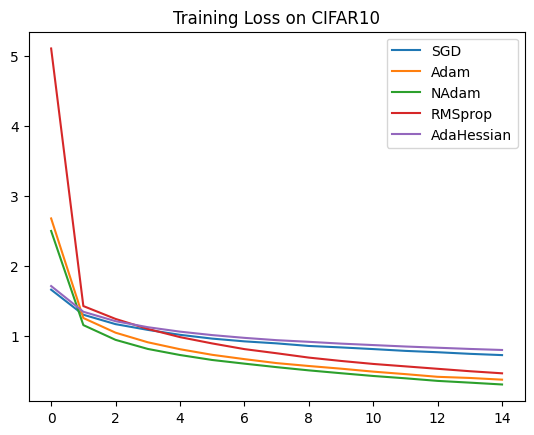

In [ ]:
epoch_lst = range(15)
plt.plot(epoch_lst, loss_lst_SGD, label = "SGD")
plt.plot(epoch_lst, loss_lst_Adam, label = "Adam")
plt.plot(epoch_lst, loss_lst_NAdam, label = "NAdam")
plt.plot(epoch_lst, loss_lst_RMSprop, label = "RMSprop")
plt.plot(epoch_lst, loss_lst_Adahess, label = "AdaHessian")
plt.legend()
plt.title('Training Loss on CIFAR10')
plt.savefig('Training Loss on CIFAR10.png')
plt.show()

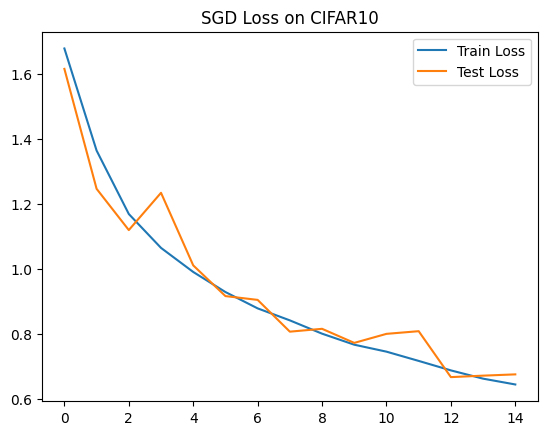

In [68]:
epoch_lst = range(15)
plt.plot(epoch_lst, loss_lst_SGD, label = "Train Loss")
plt.plot(epoch_lst, testloss_SGD, label = "Test Loss")
plt.legend()
plt.title('SGD Loss on CIFAR10')
plt.savefig('SGD Loss on CIFAR10.png')
plt.show()

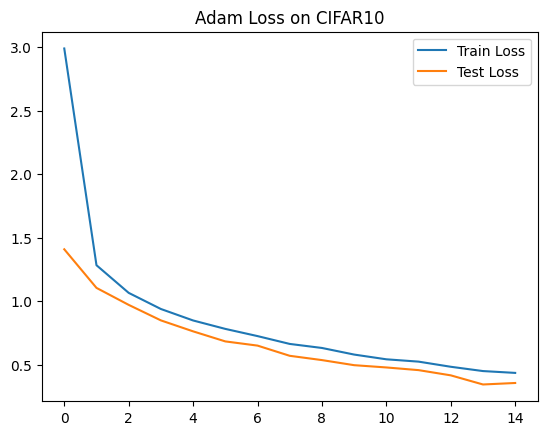

In [69]:
epoch_lst = range(15)
plt.plot(epoch_lst, loss_lst_Adam, label = "Train Loss")
plt.plot(epoch_lst, testloss_Adam, label = "Test Loss")
plt.legend()
plt.title('Adam Loss on CIFAR10')
plt.savefig('Adam Loss on CIFAR10.png')
plt.show()

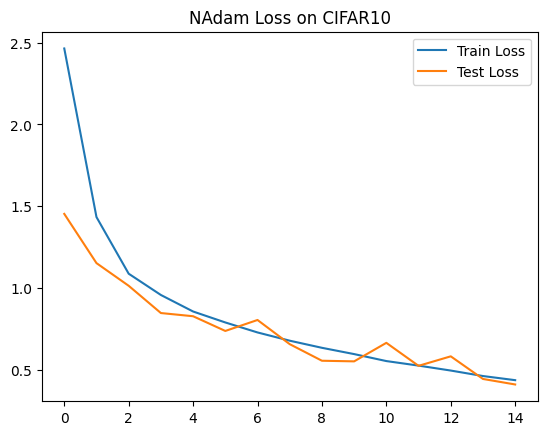

In [70]:
epoch_lst = range(15)
plt.plot(epoch_lst, loss_lst_NAdam, label = "Train Loss")
plt.plot(epoch_lst, testloss_NAdam, label = "Test Loss")
plt.legend()
plt.title('NAdam Loss on CIFAR10')
plt.savefig('NAdam Loss on CIFAR10.png')
plt.show()

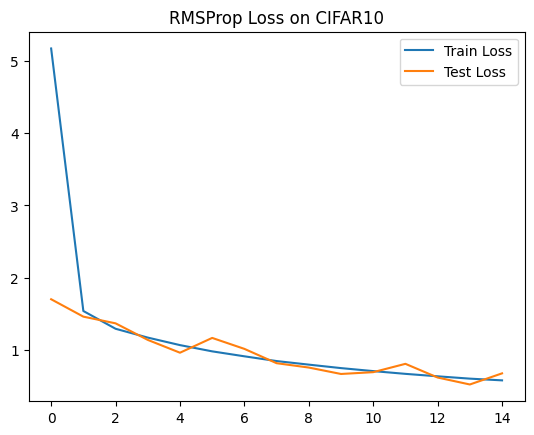

In [71]:
epoch_lst = range(15)
plt.plot(epoch_lst, loss_lst_RMSprop, label = "Train Loss")
plt.plot(epoch_lst, testloss_RMSProp, label = "Test Loss")
plt.legend()
plt.title('RMSProp Loss on CIFAR10')
plt.savefig('RMSProp Loss on CIFAR10.png')
plt.show()

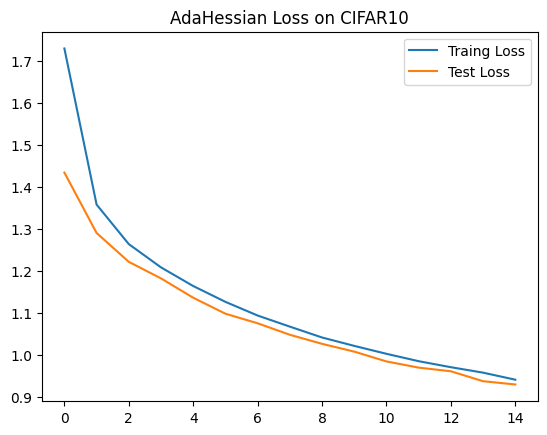

In [72]:
epoch_lst = range(15)
plt.plot(epoch_lst, loss_lst_Adahess, label = "Traing Loss")
plt.plot(epoch_lst, testloss_Adahess, label = "Test Loss")
plt.legend()
plt.title('AdaHessian Loss on CIFAR10')
plt.savefig('AdaHessian Loss on CIFAR10.png')
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

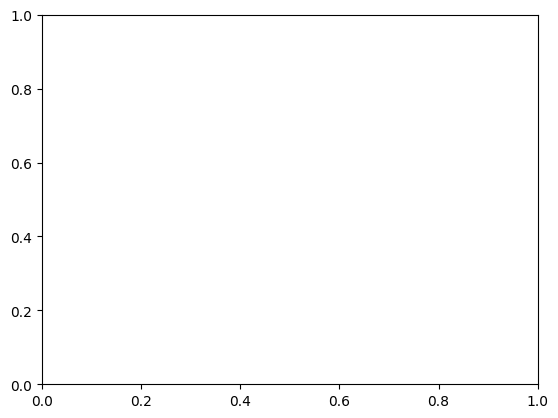

In [73]:
epoch_lst = range(15)
plt.plot(epoch_lst, testacc_SGD, label = "SGD")
plt.plot(epoch_lst, testacc_Adam, label = "Adam")
plt.plot(epoch_lst, testacc_NAdam, label = "NAdam")
plt.plot(epoch_lst, testacc_RMSprop, label = "RMSprop")
plt.plot(epoch_lst, testacc_Adahess, label = "AdaHessian")
plt.legend()
plt.title('Testing Accuracy on CIFAR10')
plt.savefig('Testing Accuracy on CIFAR10.png')
plt.show()